Training DCGAN on the Celeb Dataset
=====



[https://keras.io/examples/generative/dcgan_overriding_train_step/](https://keras.io/examples/generative/dcgan_overriding_train_step/)

To run notebook you will need to install [gdown](https://pypi.org/project/gdown/), a library to download large files from Google Drive.

In [1]:
!pip install gdown

  Using cached gdown-4.6.4-py3-none-any.whl (14 kB)


Now let's import the necessary modules

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display # we will use this to clear the results 
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import gdown
from zipfile import ZipFile

## Prepare Celeb data



In this example we will use the Celeb dataset. We will resize images to a size of `64x64`.
First download the dataset (only need to do this once, then it will throw an error but don&rsquo;t worry):



In [5]:
if not os.path.isdir("datasets/celeba_gan/img_align_celeba"):
    print("Downloading Celeba dataset")
    os.makedirs("./datasets/celeba_gan", exist_ok=True)

    url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
    output = "./datasets/celeba_gan/data.zip"
    gdown.download(url, output, quiet=False)
    
    print("Unzipping")
    with ZipFile("./datasets/celeba_gan/data.zip", "r") as zipobj:
        zipobj.extractall("datasets/celeba_gan")
else:
    print("Celeb directory exists")
print("Done")

Celeb directory exists
Done


Check if the unzipping worked. If it did not either manually download the dataset from this [link](https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684) or if download work manually unzip.

Now let's convert this to a Tensorflow dataset. Because we expect to be training on our laptops, we will reduce the size of the training set. The number of training examples we use is defined in the `dataset_size` variable. While this is not ideal for GANs, it will still produce "reasonable" results. If you train this with your own dataset you will want to comment the line:
```python
dataset = dataset.take(dataset_size) 
```

The code below also forces the image size to square 64x64 pixel images. The size of one side is defined in the `image_size` variable. Feel free to increase this size, but while the training should work also with larger sizes this is not thoroughly tested. 

In this code we also scale the inputs to the `[-1, 1]` range and make sure the dataset is subdivided into batches of the desired size.

In [6]:
dataset_path = "datasets/celeba_gan" # Change this for your custom dataset
image_size = 64 # images are square
image_channels = 3 # 3 RGB 1 Grayscale
image_shape = (image_size, image_size, image_channels)
dataset_size = 300 
batch_size = 32

dataset = keras.utils.image_dataset_from_directory(
    dataset_path, label_mode=None, image_size=(image_size, image_size), batch_size=None)

# Note. comment the following line if you will use your own dataset
dataset = dataset.take(dataset_size) 

dataset = dataset.map(lambda x: x / 127.5 - 1.0) # Scales data from [0,255] range to [-1, 1] range
dataset = dataset.batch(batch_size) # We create batch here since "take" would unbatch it..

Found 202599 files belonging to 1 classes.
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Now let&rsquo;s see one random instance from the dataset:

2023-02-28 13:23:41.469975: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


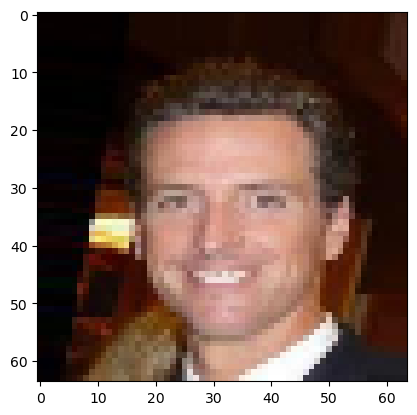

In [7]:
for x in dataset:
    plt.imshow((x.numpy() * 127.5 + 127.5).astype("int32")[0])
    break

## Create generator



At this staget we need to construct our generator. There are many implementations out there, this is one that works reasonably well for our use case and it is adapted from [here](https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py).
For GAN models it is [recommended](https://machinelearningmastery.com/how-to-code-generative-adversarial-network-hacks/) to initialize the layers with normally distributed (Gaussian) values and standard deviation of 0.02. The following function is built to enable training on different image sizes, but we recommend sticking with the `64x64` image size. You can vary the value of `kernel_size` to either `3`, `4` and `5` and see how that affects your image quality. A larger kernel size might produce better images in some cases, but will result in slower training. The code also has comments where you can experiment with modifications

In [70]:
latent_dim = 100 # The size of the latent space, try 128 also but this change will need to be reflected in notebooks/scripts that visualize the results
kernel_size = 3 # Set to either 3, 4 or 5

# This will initialize our layers randomly
init = lambda: tf.keras.initializers.RandomNormal(stddev=0.02)

# Define a generator convolutional block
def gen_block(size, batch_norm=True):
    return keras.Sequential(
        [
            layers.UpSampling2D(),
            layers.Conv2D(size, kernel_size, padding='same', kernel_initializer=init(), use_bias=False),
            # layers.Activation("relu"), Try switching between this and the following LeakyReLU
            layers.LeakyReLU(alpha=0.05), 
            layers.BatchNormalization(momentum=0.9),
        ]   
    )

# From https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py
# This will enable working with image sizes other than 64x64 (untested)
upsample_layers = 5 # Do not change
start_size =  image_size // (2 ** upsample_layers)
starting_filters = 128

generator = keras.Sequential(
    [
        layers.Input(shape=(latent_dim,)),
        layers.Dense(starting_filters * start_size * start_size, activation="relu"),
        layers.Reshape((start_size, start_size, starting_filters)),
        layers.BatchNormalization(momentum=0.9), 
        gen_block(1024),
        gen_block(512),
        gen_block(128),
        gen_block(64),
        gen_block(32),
        layers.Conv2D(3, kernel_size=kernel_size, padding="same", activation="tanh", kernel_initializer=init()),
    ]
)

generator.summary(expand_nested=True, line_length=100)

Model: "sequential_226"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 dense_16 (Dense)                            (None, 512)                             51712          
                                                                                                    
 reshape_11 (Reshape)                        (None, 2, 2, 128)                       0              
                                                                                                    
 batch_normalization_144 (BatchNormalization  (None, 2, 2, 128)                      512            
 )                                                                                                  
                                                                                                    
 sequential_221 (Sequential)                 (None, 4, 4, 1024)    

Let&rsquo;s see it&rsquo;s output before training



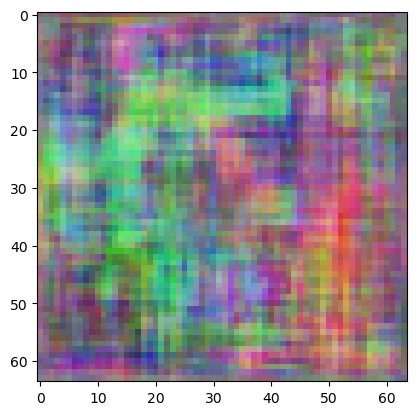

In [65]:
noise = tf.random.normal([1, latent_dim])
generated_image = generator(noise, training=True)
plt.imshow(generated_image[0, :, :]*0.5+0.5)
plt.show()

## Create discriminator



We then define the discriminator model, again adapted adapted from [here](https://github.com/Kaustubh1Verma/Art-using-GANs/blob/ff41eeb5099d2aa3976ed1f051596d14015548d5/DCGAN/DCGAN.py).



In [71]:
# Define a discriminator convolutional block
def disc_block(size, strides, batch_norm=True, padding=False, dropout=False):
    layer_list = [
                  layers.Conv2D(size, kernel_size=kernel_size, strides=strides, padding="same", kernel_initializer=init(), use_bias=not batch_norm), # Always keep
                  layers.LeakyReLU(alpha=0.2), # Always keep
                  ]
    if dropout: 
        layer_list += [layers.Dropout(0.3)] # Try varying the Dropout probabilty, keep the value <= 0.5
    if padding:
        layer_list += [layers.ZeroPadding2D(padding=((0,1),(0,1)))] # Always keep this
    if batch_norm:
        layer_list += [layers.BatchNormalization(momentum=0.8)] 
    return keras.Sequential(layer_list)

discriminator = keras.Sequential(
    [
        keras.Input(shape=image_shape),
        layers.GaussianNoise(0.2), # Injects noise into discriminator. Try varying noise amount <= 0.2, or removing by commenting this line
        disc_block(32, 1, batch_norm=False), # Try varying the dropout flag in these layers
        disc_block(64, 2, batch_norm=True, padding=True),
        disc_block(128, 2, batch_norm=True),
        disc_block(256, 2, batch_norm=True),
        disc_block(512, 2, batch_norm=False, dropout=True),
        layers.Flatten(),
        layers.Dense(1, activation="sigmoid"),
    ]
)   
        
discriminator.summary(expand_nested=True)

Model: "sequential_232"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise_26 (Gaussian  (None, 64, 64, 3)        0         
 Noise)                                                          
                                                                 
 sequential_227 (Sequential)  (None, 64, 64, 32)       896       
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_221 (Conv2D)       (None, 64, 64, 32)        896       |
|                                                               |
| leaky_re_lu_189 (LeakyReLU)  (None, 64, 64, 32)     0         |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 sequential_228 (Sequential)  (None, 33, 33, 64)       18688     
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| conv2d_222 (Conv2D)       (None, 32, 32, 64)        18432     |
|                                                   

# Train the network
Tensorflow and Keras offer many ways to combine the generator and discriminator into a GAN model and train it. Here we follow one approach that appears to work relatively well for a small number of images, in which we manually define the training loop. The loop will save images and models for each ["epoch"](https://deepai.org/machine-learning-glossary-and-terms/epoch) to a directory specifed in the variable `model_path`. You can visualize the results by examining the directory. Keep note of this directory, because you will use that to load and visualize images in the [06_visualizing_gan_results.ipynb](06_visualizing_gan_results.ipynb) notebook. You may want to name the directory in a way that reminds you of the parameters you used for training. As usual, examine the code below and look out for comments that indicate paramters that you can modify.

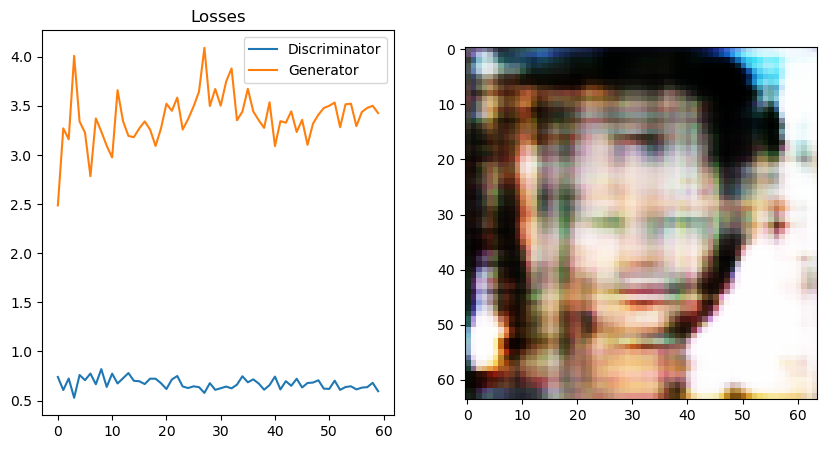

Saving epoch 60 to ./models/dcgan_dmlap_2


In [72]:
model_path = "./models/dcgan_dmlap" # Can change. Model files and resulting images will be saved in this directory
os.makedirs(model_path, exist_ok=True) # this actually creates the directory if it does not exist

learning_rate = 0.0002 # Experiment with changing this. Lower values result in slower but perhaps more stable learning 
smoothing = 0.1         # Label smoothing (keep < 0.2), can improve results. Setting to zero will disable smoothing 

epochs = 60             # Number of epochs. Safe to increase but check what happens to the images
save_interval = 1       # Defines how often to save the model, 1 is every epoch

# DO NOT MODIFY CODE BELOW THIS
# The loss function for discriminator and generator
loss_function = tf.keras.losses.BinaryCrossentropy() 

def discriminator_loss(real_output, fake_output):
    # real_loss will quantify our loss to distinguish the real images
    real_loss = loss_function(tf.ones_like(real_output)*(1.0 - smoothing), real_output)

    # fake_loss will quantify our loss to distinguish the fake images (generated)
    fake_loss = loss_function(tf.zeros_like(fake_output), fake_output)
    
    # Real image = 1, Fake image = 0 (array of ones and zeros)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # We want the false images to be seen as real images (1)
    return loss_function(tf.ones_like(fake_output), fake_output)

# Optimizers for generator and discriminator
generator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.5, beta_2=0.9) 
discriminator_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate, beta_1=0.5, beta_2=0.9) 

# Override the train step
@tf.function # <- this will tell Tensorflow to optimize for faster execution
def train_step(images):
    batch_size = tf.shape(images)[0]
    noise = tf.random.normal([batch_size, latent_dim])

    # To make sure we know what is done, we will use a gradient tape instead of compiling
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Training the generator
        generated_images = generator(noise , training=True) 

        # Training the discriminator
        real_output = discriminator(images, training=True)           # Training the discriminator on real images
        fake_output = discriminator(generated_images, training=True) # Training the discriminator on fake images

        # Calculating the losses
        gen_loss =  generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        # Building the gradients
        gradients_of_generator =     gen_tape.gradient( gen_loss,  generator.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        
        # Applying the gradients (backpropagation)
        generator_optimizer.apply_gradients(    zip(gradients_of_generator,     generator.trainable_variables))
        discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

        return gen_loss, disc_loss
    
# Training loop
g_losses = []
d_losses = []

display.clear_output(wait=True) # clear

for epoch in range(epochs):
    n = dataset.cardinality() # The number of batches per epoch
    # Iterate over all batches
    batch_d_losses = []
    batch_g_losses = []
    for i, batch in enumerate(dataset):
        # Updte parameters for this batch
        g_loss, d_loss = train_step(batch)
        
        # Store losses for batch, we will average these for the whole epoch for a more stable visualization
        batch_g_losses.append(g_loss)
        batch_d_losses.append(d_loss)
        
        sys.stdout.write("\r" + "Epoch %d - batch %d of %d "%(epoch+1, i+1, n) + "[D loss: "+str(d_loss)+ " | G loss: "+str(g_loss)+"]")

    # Book-keeping:
    # Visualize losses and one example image for the epoch
    g_losses.append(np.mean(batch_g_losses))
    d_losses.append(np.mean(batch_d_losses))
    display.clear_output(wait=True)
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.title('Losses')
    xepoch = list(range(epoch+1))
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.legend()
    plt.subplot(1,2,2)
    random_latent_vectors = tf.random.normal(shape=(1, latent_dim))
    generated_images = generator(random_latent_vectors, training=False).numpy()*0.5 + 0.5
    plt.imshow(generated_images[0])        
    plt.show()

    # Save some example images and store model file
    if epoch % save_interval == 0:
        print('Saving epoch %d to %s'%(epoch+1, model_path))
        num_examples = 5
        random_latent_vectors = tf.random.normal(shape=(num_examples, latent_dim))
        generated_images = generator(random_latent_vectors, training=False)
        generated_images = generated_images * 127.5 + 127.5 
        generated_images.numpy()
        for i in range(num_examples):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save(os.path.join(model_path, "e%03d_generated_img_%d.png" % (epoch+1, i)))
        generator.save(os.path.join(model_path, "e%0d_generator.hd5"%(epoch+1)), save_format='h5')


# Notes
Training DCGANs is hard. Here are some useful tricks:
- Geneal tricks: https://github.com/soumith/ganhacks/blob/master/README.md
- Instance noise (using this in discriminator): https://www.inference.vc/instance-noise-a-trick-for-stabilising-gan-training/
- Improved techniques for training GANs (2016 paper): https://arxiv.org/pdf/1606.03498.pdf
- "Gan guide" with some nice research and code examples on which this notebook is also based: https://github.com/garridoq/gan-guide

